In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.misc
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
# Load VGG16
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
def create_bins(x):
    # Apply Freedman–Diaconis rule to find optimal bins witdh.
    
    # q25, q75 = np.percentile(x, [.25,.75])
    q25, q75 = tfp.stats.percentile(x, q=[25., 75.])
    IQR = q75 - q25
    bin_width = 2*(IQR / (len(x)**(1/3)))
    # bins = round((x.max() - x.min())/bin_width)
    bins = int(tf.math.round((tf.reduce_max(x) - tf.reduce_min(x))/bin_width))

    print("Freedman–Diaconis number of bins:", bins)
    return int(bins)

# Train on Dense

- Expected plot is from GoogLeNet inception_5b3x3 layer.
- According to author, they found this progression of weight distribution **very representive for VGGNet and ResNet** as well.

## a) Conv layer

In [4]:
# block5_conv3 (Conv2D)
# Take 1st block among the 3 Conv block.
# w = np.array(model.layers[-6].weights[0][0])
w = model.layers[-6].weights[0][0]
w.shape

TensorShape([3, 512, 512])

Freedman–Diaconis number of bins: 1193


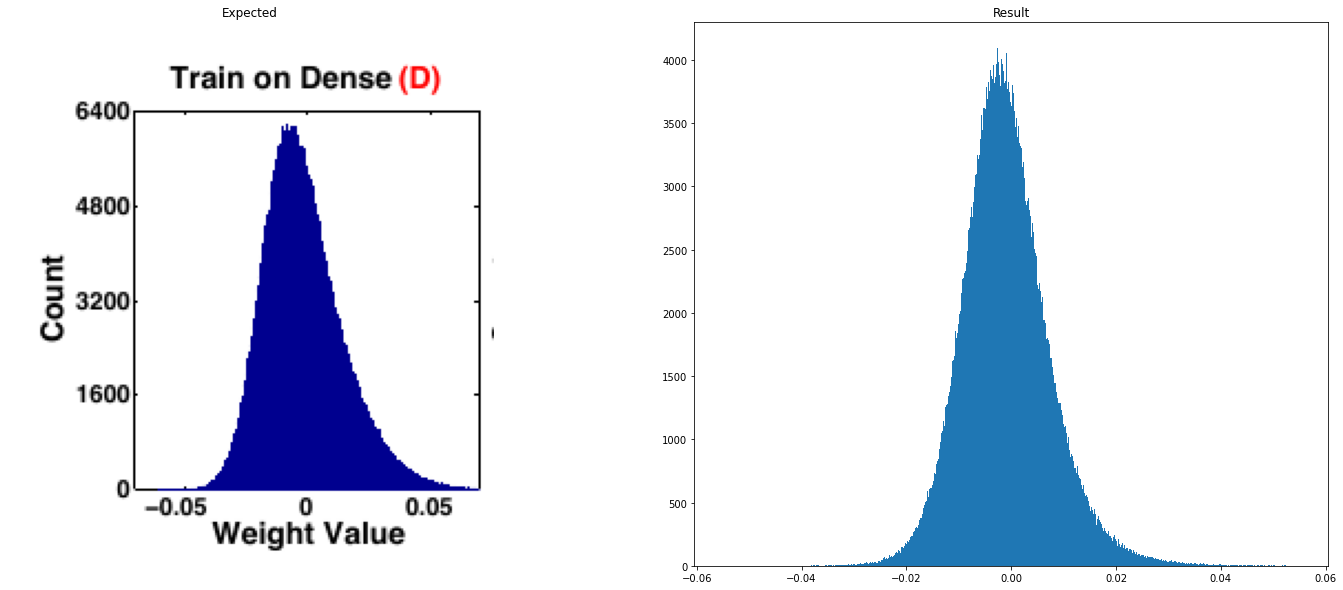

In [5]:
fig = plt.figure(figsize=(25,10))

# --- Expected ---
fig.add_subplot(1,2,1)
plt.title("Expected")
plt.axis('off')
img = mpimg.imread("../img/test_1.png")
plt.imshow(img)

# --- Result ---
fig.add_subplot(1,2,2)
# x = w.flatten()
x = tf.reshape(w, [-1])
bins = create_bins(x)

plt.title("Result")
plt.hist(x.numpy(), bins = bins, range=(-0.055, 0.055));

## b) Dense layer

In [16]:
# Dense
# w = model.layers[-2].weights[0]
# w.shape

In [15]:
# fig = plt.figure(figsize=(15,10))

# # --- Expected ---
# fig.add_subplot(1,2,1)
# plt.title("Expected")
# plt.axis('off')
# img = mpimg.imread("../img/test_1.png")
# plt.imshow(img)

# # --- Result ---
# fig.add_subplot(1,2,2)
# # x = w.flatten()
# x = tf.reshape(w, [-1])
# bins = create_bins(x)

# plt.title("Result")
# plt.hist(x.numpy(), bins = bins, range=(-0.055, 0.055));

# Pruning the network

## a) Conv layer

In [22]:
sparsity = 0.5
# of layer ? Dunno so far.
N = 1
k = N * (1 - sparsity)
k

0.5

In [23]:
# block5_conv3 (Conv2D)
# Take 1st block among the 3 Conv block.
# w = np.array(model.layers[-6].weights[0][0])
w = model.layers[-6].weights[0][0]
w.shape

TensorShape([3, 512, 512])

In [24]:
qk = tfp.stats.percentile(tf.math.abs(w), q=(1 - k) * 100)
pruned = tf.where(tf.math.abs(w) < qk, 0, w)

non_zero = tf.math.count_nonzero(pruned)
total = tf.reshape(w, [-1]).shape[0]
print("Percentage of non zero value:", (non_zero / total).numpy())

Freedman–Diaconis number of bins: 1907


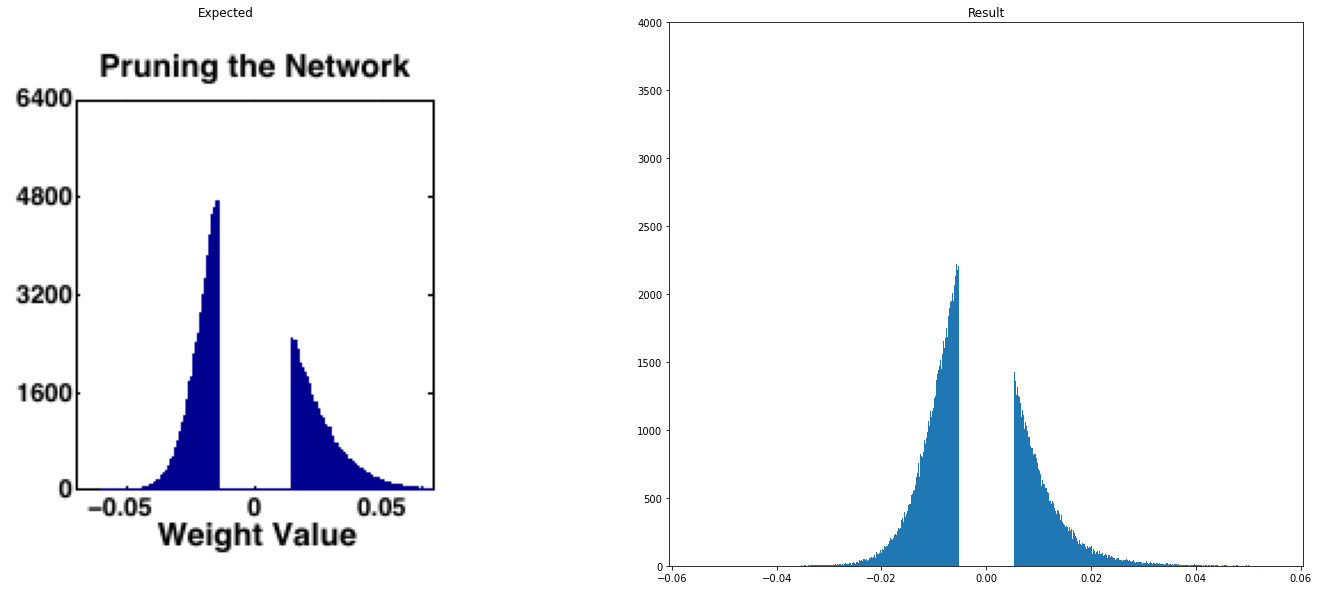

In [27]:
fig = plt.figure(figsize=(25,10))

# --- Expected ---
fig.add_subplot(1,2,1)
plt.title("Expected")
plt.axis('off')
img = mpimg.imread("../img/test_2.png")
plt.imshow(img)

# --- Result ---
fig.add_subplot(1,2,2)
x = tf.reshape(pruned, [-1])
bins = create_bins(x)
plt.title("Result")
plt.ylim(top=4000)
plt.hist(x.numpy(), bins = bins, range=(-0.055, 0.055));

## b) Dense layer

In [17]:
# sparsity = 0.5
# # of layer ? Dunno so far.
# N = 1
# k = N * (1 - sparsity)
# k

In [18]:
# qk = tfp.stats.percentile(tf.math.abs(w), q=(1 - k) * 100)
# pruned = tf.where(tf.math.abs(w) < qk, 0, w)

In [19]:
# non_zero = tf.math.count_nonzero(pruned)
# total = tf.reshape(w, [-1]).shape[0]
# print("Percentage of non zero value:", (non_zero / total).numpy())

In [20]:
# x = tf.reshape(pruned, [-1])
# bins = create_bins(x)
# plt.title("Result")
# plt.ylim(top=2 * 1e5)
# plt.hist(x.numpy(), bins = bins, range=(-0.055, 0.055));